# Survey Candidate Selection: Author Pairs for Beyond-H-Index Validation

This notebook identifies author pairs for survey-based validation of the Beyond-H-Index ranking system. We select pairs that are similar in one ranking system but dramatically different in the other to test expert preferences.

## Objective
- Select researcher pairs with similar H-index ranks but dramatically different composite ranks (≥100 positions)
- Select researcher pairs with similar composite ranks but dramatically different H-index ranks (≥100 positions)
- Create a focused selection of maximum 20 pairs total
- Generate only final survey-ready data (no intermediate files)
- Focus on extreme ranking disagreements to maximize survey impact

## Selection Strategy
- **Type 1**: Similar H-index ranks (±10 positions) but dramatically different composite ranks (≥100 positions)
- **Type 2**: Similar composite ranks (±10 positions) but dramatically different H-index ranks (≥100 positions)
- **Quality focus**: Well-known researchers with sufficient publication history
- **Final output**: Only export the final selected pairs for survey use (no intermediate files)

In [56]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("📚 Libraries imported successfully")
print(f"📅 Selection process started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📚 Libraries imported successfully
📅 Selection process started: 2025-09-22 22:35:57


In [57]:
# Load Data Sources
print("🔄 Loading data sources...")

# Load the main researcher dataset
try:
    df = pd.read_csv('nlp_researcher_metrics.csv')
    print(f"✅ Loaded main dataset: {df.shape[0]} researchers, {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ Main dataset not found. Please ensure 'nlp_researcher_metrics.csv' exists.")
    df = None

# Load any existing rankings if available
h_index_rankings = None
composite_rankings = None

try:
    h_index_rankings = pd.read_csv('h_index_rankings.csv')
    print(f"✅ Loaded H-index rankings: {h_index_rankings.shape[0]} researchers")
except FileNotFoundError:
    print("⚠️ H-index rankings not found - will generate from main dataset")

try:
    composite_rankings = pd.read_csv('composite_score_rankings.csv')
    print(f"✅ Loaded composite rankings: {composite_rankings.shape[0]} researchers")
except FileNotFoundError:
    print("⚠️ Composite rankings not found - will generate from main dataset")

if df is not None:
    print(f"\n📊 Dataset overview:")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Date range: {df['first_year'].min() if 'first_year' in df.columns else 'N/A'} - {df['last_year'].max() if 'last_year' in df.columns else 'N/A'}")
    print(f"   H-index range: {df['h_index'].min() if 'h_index' in df.columns else 'N/A'} - {df['h_index'].max() if 'h_index' in df.columns else 'N/A'}")

🔄 Loading data sources...
✅ Loaded main dataset: 1000 researchers, 18 columns
✅ Loaded H-index rankings: 1000 researchers
✅ Loaded composite rankings: 1000 researchers

📊 Dataset overview:
   Columns: ['author_id', 'name', 'total_paper_count', 'total_citation_count', 'h_index', 'institution', 'first_publication_year', 'last_publication_year', 'career_span', 'avg_papers_per_year', 'first_author_count', 'last_author_count', 'mode_venue', 'unique_venues', 'venue_diversity', 'venue_types', 'conference_journal_ratio', 'citations_per_paper']
   Date range: N/A - N/A
   H-index range: 1 - 159


In [58]:
# Define Selection Criteria
print("📋 SURVEY CANDIDATE SELECTION CRITERIA")
print("=" * 50)

# Define the core selection parameters
SELECTION_CRITERIA = {
    'rank_tolerance': 10,           # Max difference for "similar" ranks
    'min_dramatic_diff': 100,       # Min difference for "dramatic" differences (increased from 50)
    'max_total_pairs': 20,          # Maximum total pairs (both types combined)
    'min_h_index': 30,              # Minimum H-index for inclusion
    'min_papers': 20,               # Minimum number of papers
    'min_career_span': 5,           # Minimum 5 years of publication history
    'target_type1_pairs': 10,       # Target pairs: similar H-index, different composite
    'target_type2_pairs': 10,       # Target pairs: similar composite, different H-index
}

print("Selection Criteria:")
for key, value in SELECTION_CRITERIA.items():
    print(f"  • {key.replace('_', ' ').title()}: {value}")

print("\nSelection Strategy:")
print("  • Type 1: Similar H-index ranks (±10), Dramatically different composite ranks (≥100)")
print("  • Type 2: Similar composite ranks (±10), Dramatically different H-index ranks (≥100)")
print("  • Goal: Maximum dramatic ranking disagreement for clear survey choices")
print("  • Output: Final pairs only (NO intermediate files saved)")

print("\nFile Output Policy:")
print("  • NO intermediate CSV files")
print("  • NO selection logs during processing")
print("  • ONLY final survey data at the end")

📋 SURVEY CANDIDATE SELECTION CRITERIA
Selection Criteria:
  • Rank Tolerance: 10
  • Min Dramatic Diff: 100
  • Max Total Pairs: 20
  • Min H Index: 30
  • Min Papers: 20
  • Min Career Span: 5
  • Target Type1 Pairs: 10
  • Target Type2 Pairs: 10

Selection Strategy:
  • Type 1: Similar H-index ranks (±10), Dramatically different composite ranks (≥100)
  • Type 2: Similar composite ranks (±10), Dramatically different H-index ranks (≥100)
  • Goal: Maximum dramatic ranking disagreement for clear survey choices
  • Output: Final pairs only (NO intermediate files saved)

File Output Policy:
  • NO intermediate CSV files
  • NO selection logs during processing
  • ONLY final survey data at the end


In [59]:
# Filter Author Pairs - Initial Filtering
print("🔍 INITIAL FILTERING OF RESEARCHER POOL")
print("=" * 50)

if df is None:
    print("❌ Cannot proceed without data. Please check data loading.")
else:
    # Start with the full dataset
    df_filtered = df.copy()
    
    print(f"Starting pool: {len(df_filtered)} researchers")
    
    # Apply basic quality filters
    if 'h_index' in df_filtered.columns:
        initial_count = len(df_filtered)
        df_filtered = df_filtered[df_filtered['h_index'] >= SELECTION_CRITERIA['min_h_index']]
        print(f"After H-index filter (≥{SELECTION_CRITERIA['min_h_index']}): {len(df_filtered)} (-{initial_count - len(df_filtered)})")
    
    if 'total_papers' in df_filtered.columns:
        initial_count = len(df_filtered)
        df_filtered = df_filtered[df_filtered['total_papers'] >= SELECTION_CRITERIA['min_papers']]
        print(f"After papers filter (≥{SELECTION_CRITERIA['min_papers']}): {len(df_filtered)} (-{initial_count - len(df_filtered)})")
    
    # Filter for career span if available
    if 'career_span' in df_filtered.columns:
        initial_count = len(df_filtered)
        df_filtered = df_filtered[df_filtered['career_span'] >= SELECTION_CRITERIA['min_career_span']]
        print(f"After career span filter (≥{SELECTION_CRITERIA['min_career_span']} years): {len(df_filtered)} (-{initial_count - len(df_filtered)})")
    
    # Remove researchers with insufficient data
    initial_count = len(df_filtered)
    required_cols = ['h_index', 'total_citations', 'total_papers']
    available_cols = [col for col in required_cols if col in df_filtered.columns]
    
    if available_cols:
        df_filtered = df_filtered.dropna(subset=available_cols)
        print(f"After removing incomplete data: {len(df_filtered)} (-{initial_count - len(df_filtered)})")
    
    # Calculate composite scores if not already present
    if 'composite_score' not in df_filtered.columns:
        print("\n🧮 Calculating composite scores...")
        
        # Use the correct column names from the dataset
        citation_col = 'total_citations' if 'total_citations' in df_filtered.columns else 'total_citation_count'
        papers_col = 'total_papers' if 'total_papers' in df_filtered.columns else 'total_paper_count'
        
        # Recreate the composite scoring function
        def calculate_composite_score(row):
            # Normalize each component (0-1 scale)
            max_citations = df_filtered[citation_col].max()
            max_papers = df_filtered[papers_col].max()
            max_h_index = df_filtered['h_index'].max()
            
            # Citation Impact (40%)
            citation_impact = (row[citation_col] / max_citations) * 0.4
            
            # Research Productivity (25%)
            productivity = (row[papers_col] / max_papers) * 0.25

            # H-index component (20%)
            h_component = (row['h_index'] / max_h_index) * 0.2
            
            # Quality focus (10%) - citations per paper
            quality = (row[citation_col] / max(row[papers_col], 1)) / (max_citations / max_papers) * 0.1
            
            # Career-adjusted factor (5%)
            career_factor = 0.05  # Simplified for now
            
            return citation_impact + productivity + h_component + quality + career_factor
        
        df_filtered['composite_score'] = df_filtered.apply(calculate_composite_score, axis=1)
        print("✅ Composite scores calculated")
    
    # Create rankings
    df_filtered['h_index_rank'] = df_filtered['h_index'].rank(ascending=False, method='min').astype(int)
    df_filtered['composite_rank'] = df_filtered['composite_score'].rank(ascending=False, method='min').astype(int)
    
    print(f"\n✅ Filtered dataset ready: {len(df_filtered)} researchers")
    print(f"   H-index range: {df_filtered['h_index'].min():.0f} - {df_filtered['h_index'].max():.0f}")
    print(f"   Composite score range: {df_filtered['composite_score'].min():.3f} - {df_filtered['composite_score'].max():.3f}")
    
    # Show distribution of ranking differences
    df_filtered['rank_difference'] = abs(df_filtered['h_index_rank'] - df_filtered['composite_rank'])
    
    print(f"\n📊 Ranking difference distribution:")
    print(f"   Mean difference: {df_filtered['rank_difference'].mean():.1f} positions")
    print(f"   Dramatic differences (≥100): {len(df_filtered[df_filtered['rank_difference'] >= 100])} researchers")
    print(f"   Extreme differences (≥200): {len(df_filtered[df_filtered['rank_difference'] >= 200])} researchers")

🔍 INITIAL FILTERING OF RESEARCHER POOL
Starting pool: 1000 researchers
After H-index filter (≥30): 217 (-783)
After career span filter (≥5 years): 215 (-2)
After removing incomplete data: 215 (-0)

🧮 Calculating composite scores...
✅ Composite scores calculated

✅ Filtered dataset ready: 215 researchers
   H-index range: 30 - 159
   Composite score range: 0.119 - 0.979

📊 Ranking difference distribution:
   Mean difference: 19.1 positions
   Dramatic differences (≥100): 0 researchers
   Extreme differences (≥200): 0 researchers


In [60]:
df_filtered

,author_id,name,total_paper_count,total_citation_count,h_index,institution,first_publication_year,last_publication_year,career_span,avg_papers_per_year,first_author_count,last_author_count,mode_venue,unique_venues,venue_diversity,venue_types,conference_journal_ratio,citations_per_paper,composite_score,h_index_rank,composite_rank,rank_difference
1,2531268,Alexander M. Rush,138,24080,57,Cornell Tech,1998,2023,26,5.307692,12,72,Conference on Empirical Methods in Natural Lan...,35.0,0.781246,"{'conference': 90, 'journal': 12}",7.500000,174.492754,0.207893,60,80,20
5,5293769,J. Devylder,212,5223,40,NaN,2008,2025,18,11.777778,67,77,Schizophrenia Research,66.0,0.839482,{'journal': 184},0.000000,24.636792,0.162887,132,126,6
19,2026545715,Preslav Nakov,205,4124,36,NaN,2003,2025,23,8.913043,21,69,arXiv.org,56.0,0.788417,"{'conference': 106, 'journal': 15}",7.066667,20.117073,0.154388,155,149,6
21,1982950,Luke Zettlemoyer,275,102722,111,University of Washington,1998,2023,26,10.576923,16,137,Conference on Empirical Methods in Natural Lan...,43.0,0.704901,"{'conference': 203, 'journal': 15}",13.533333,373.534545,0.407990,7,11,4
24,1384550891,Xiang Ren,132,6246,38,NaN,2013,2023,11,12.000000,6,79,Conference on Empirical Methods in Natural Lan...,26.0,0.735777,"{'conference': 72, 'journal': 10}",7.200000,47.318182,0.145034,145,174,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,2522197,F. Matthes,418,6078,37,NaN,1989,2023,35,11.942857,45,253,Americas Conference on Information Systems,171.0,0.922702,"{'conference': 202, 'journal': 27}",7.481481,14.540670,0.210318,149,77,72
984,1831176,Walt Detmar Meurers,225,5954,39,NaN,1993,2025,33,6.818182,69,173,BEA@NAACL-HLT,57.0,0.912247,"{'conference': 45, 'journal': 22}",2.045455,26.462222,0.165838,137,123,14
990,103476203,Stella Biderman,50,13171,31,Booz Allen Hamilton,2015,2024,10,5.000000,9,9,arXiv.org,18.0,0.791933,"{'conference': 20, 'journal': 3}",6.666667,263.420000,0.161120,201,130,71
994,2620563,Longxiang Gao,195,4612,32,NaN,2009,2024,16,12.187500,24,57,IEEE Internet of Things Journal,90.0,0.920198,"{'journal': 77, 'conference': 36}",0.467532,23.651282,0.147845,193,164,29


In [61]:
# Apply Ranking Validation Logic - Select Both Types of Dramatic Pairs
print("⚖️ SELECTING DRAMATIC RANKING DISAGREEMENT PAIRS")
print("=" * 60)

def select_dramatic_pairs(df, rank_tolerance=10, min_dramatic_diff=100, target_type1=10, target_type2=10):
    """
    Select two types of pairs:
    Type 1: Similar H-index ranks, dramatically different composite ranks
    Type 2: Similar composite ranks, dramatically different H-index ranks
    
    Parameters:
    - df: DataFrame with h_index_rank and composite_rank columns
    - rank_tolerance: Maximum difference for "similar" ranks
    - min_dramatic_diff: Minimum difference for "dramatic" differences
    - target_type1: Target number of Type 1 pairs
    - target_type2: Target number of Type 2 pairs
    
    Returns:
    - List of selected pairs with type information
    """
    all_pairs = []
    used_indices = set()
    
    print(f"Selection parameters:")
    print(f"  • Rank tolerance for 'similar': ±{rank_tolerance} positions")
    print(f"  • Minimum dramatic difference: ≥{min_dramatic_diff} positions")
    print(f"  • Target Type 1 pairs (similar H, different composite): {target_type1}")
    print(f"  • Target Type 2 pairs (similar composite, different H): {target_type2}")
    print(f"  • Candidate pool: {len(df)} researchers")
    print("-" * 60)
    
    # TYPE 1: Similar H-index ranks, dramatically different composite ranks
    print("\n🔍 TYPE 1: Similar H-index ranks, dramatically different composite ranks")
    df_sorted_h = df.sort_values('h_index_rank').copy().reset_index(drop=True)
    type1_pairs = []
    
    for i, researcher1 in df_sorted_h.iterrows():
        if len(type1_pairs) >= target_type1:
            break
        if i in used_indices:
            continue
            
        # Look for researchers with similar H-index rank
        h_rank_min = researcher1['h_index_rank'] - rank_tolerance
        h_rank_max = researcher1['h_index_rank'] + rank_tolerance
        
        candidates = df_sorted_h[
            (df_sorted_h['h_index_rank'] >= h_rank_min) & 
            (df_sorted_h['h_index_rank'] <= h_rank_max) &
            (df_sorted_h.index != i) &
            (~df_sorted_h.index.isin(used_indices))
        ]
        
        best_candidate = None
        best_diff = 0
        
        for j, researcher2 in candidates.iterrows():
            composite_diff = abs(researcher1['composite_rank'] - researcher2['composite_rank'])
            
            if composite_diff >= min_dramatic_diff and composite_diff > best_diff:
                best_candidate = (j, researcher2, composite_diff)
                best_diff = composite_diff
        
        if best_candidate is not None:
            j, researcher2, composite_diff = best_candidate
            
            # Create pair with better composite rank first
            if researcher1['composite_rank'] < researcher2['composite_rank']:
                better, worse = researcher1, researcher2
                better_idx, worse_idx = i, j
            else:
                better, worse = researcher2, researcher1
                better_idx, worse_idx = j, i
            
            pair = create_pair_dict(better, worse, better_idx, worse_idx, composite_diff, 'type1_similar_h_dramatic_composite')
            type1_pairs.append(pair)
            used_indices.update([i, j])
            
            print(f"✅ Type 1 Pair {len(type1_pairs)}: {better.get('name', 'Unknown')[:25]} vs {worse.get('name', 'Unknown')[:25]}")
            print(f"   H-ranks: #{better['h_index_rank']} vs #{worse['h_index_rank']} (diff: {abs(better['h_index_rank'] - worse['h_index_rank'])})")
            print(f"   Composite-ranks: #{better['composite_rank']} vs #{worse['composite_rank']} (diff: {composite_diff})")
    
    # TYPE 2: Similar composite ranks, dramatically different H-index ranks
    print(f"\n🔍 TYPE 2: Similar composite ranks, dramatically different H-index ranks")
    df_sorted_c = df.sort_values('composite_rank').copy().reset_index(drop=True)
    type2_pairs = []
    
    for i, researcher1 in df_sorted_c.iterrows():
        if len(type2_pairs) >= target_type2:
            break
        if i in used_indices:
            continue
            
        # Look for researchers with similar composite rank
        c_rank_min = researcher1['composite_rank'] - rank_tolerance
        c_rank_max = researcher1['composite_rank'] + rank_tolerance
        
        candidates = df_sorted_c[
            (df_sorted_c['composite_rank'] >= c_rank_min) & 
            (df_sorted_c['composite_rank'] <= c_rank_max) &
            (df_sorted_c.index != i) &
            (~df_sorted_c.index.isin(used_indices))
        ]
        
        best_candidate = None
        best_diff = 0
        
        for j, researcher2 in candidates.iterrows():
            h_diff = abs(researcher1['h_index_rank'] - researcher2['h_index_rank'])
            
            if h_diff >= min_dramatic_diff and h_diff > best_diff:
                best_candidate = (j, researcher2, h_diff)
                best_diff = h_diff
        
        if best_candidate is not None:
            j, researcher2, h_diff = best_candidate
            
            # Create pair with better H-index rank first
            if researcher1['h_index_rank'] < researcher2['h_index_rank']:
                better, worse = researcher1, researcher2
                better_idx, worse_idx = i, j
            else:
                better, worse = researcher2, researcher1
                better_idx, worse_idx = j, i
            
            pair = create_pair_dict(better, worse, better_idx, worse_idx, h_diff, 'type2_similar_composite_dramatic_h')
            type2_pairs.append(pair)
            used_indices.update([i, j])
            
            print(f"✅ Type 2 Pair {len(type2_pairs)}: {better.get('name', 'Unknown')[:25]} vs {worse.get('name', 'Unknown')[:25]}")
            print(f"   Composite-ranks: #{better['composite_rank']} vs #{worse['composite_rank']} (diff: {abs(better['composite_rank'] - worse['composite_rank'])})")
            print(f"   H-ranks: #{better['h_index_rank']} vs #{worse['h_index_rank']} (diff: {h_diff})")
    
    # Combine all pairs and assign final IDs
    all_pairs = type1_pairs + type2_pairs
    for i, pair in enumerate(all_pairs, 1):
        pair['pair_id'] = i
    
    return all_pairs, len(type1_pairs), len(type2_pairs)

def create_pair_dict(better, worse, better_idx, worse_idx, dramatic_diff, pair_type):
    """Helper function to create standardized pair dictionary"""
    return {
        'pair_type': pair_type,
        'better_researcher': {
            'name': better.get('name', f"Researcher_{better_idx}"),
            'h_index': better['h_index'],
            'h_index_rank': better['h_index_rank'],
            'composite_score': better['composite_score'],
            'composite_rank': better['composite_rank'],
            'total_citations': better.get('total_citations', better.get('total_citation_count', 'N/A')),
            'total_papers': better.get('total_papers', better.get('total_paper_count', 'N/A')),
            'career_span': better.get('career_span', 'N/A')
        },
        'worse_researcher': {
            'name': worse.get('name', f"Researcher_{worse_idx}"),
            'h_index': worse['h_index'],
            'h_index_rank': worse['h_index_rank'],
            'composite_score': worse['composite_score'],
            'composite_rank': worse['composite_rank'],
            'total_citations': worse.get('total_citations', worse.get('total_citation_count', 'N/A')),
            'total_papers': worse.get('total_papers', worse.get('total_paper_count', 'N/A')),
            'career_span': worse.get('career_span', 'N/A')
        },
        'differences': {
            'h_index_rank_diff': abs(better['h_index_rank'] - worse['h_index_rank']),
            'composite_rank_diff': abs(better['composite_rank'] - worse['composite_rank']),
            'h_index_diff': abs(better['h_index'] - worse['h_index']),
            'composite_score_diff': abs(better['composite_score'] - worse['composite_score']),
            'dramatic_diff': dramatic_diff
        }
    }

# Execute the selection
if 'df_filtered' in locals() and df_filtered is not None:
    selected_pairs, type1_count, type2_count = select_dramatic_pairs(
        df_filtered, 
        rank_tolerance=SELECTION_CRITERIA['rank_tolerance'],
        min_dramatic_diff=SELECTION_CRITERIA['min_dramatic_diff'],
        target_type1=SELECTION_CRITERIA['target_type1_pairs'],
        target_type2=SELECTION_CRITERIA['target_type2_pairs']
    )
    
    print(f"\n🎯 SELECTION COMPLETED")
    print(f"   Type 1 pairs (similar H, dramatic composite diff): {type1_count}")
    print(f"   Type 2 pairs (similar composite, dramatic H diff): {type2_count}")
    print(f"   Total pairs selected: {len(selected_pairs)}")
    print(f"   No intermediate files saved (as requested)")
else:
    print("❌ Cannot proceed - filtered dataset not available")

⚖️ SELECTING DRAMATIC RANKING DISAGREEMENT PAIRS
Selection parameters:
  • Rank tolerance for 'similar': ±10 positions
  • Minimum dramatic difference: ≥100 positions
  • Target Type 1 pairs (similar H, different composite): 10
  • Target Type 2 pairs (similar composite, different H): 10
  • Candidate pool: 215 researchers
------------------------------------------------------------

🔍 TYPE 1: Similar H-index ranks, dramatically different composite ranks
✅ Type 1 Pair 1: Xiaodong Liu vs V. Castro
   H-ranks: #149 vs #145 (diff: 4)
   Composite-ranks: #59 vs #182 (diff: 123)
✅ Type 1 Pair 2: F. Matthes vs Bill Yuchen Lin
   H-ranks: #149 vs #158 (diff: 9)
   Composite-ranks: #77 vs #203 (diff: 126)
✅ Type 1 Pair 3: Thomas Wolf vs Yonghui Wu
   H-ranks: #163 vs #163 (diff: 0)
   Composite-ranks: #107 vs #210 (diff: 103)
✅ Type 1 Pair 4: D. Klakow vs Dat Quoc Nguyen
   H-ranks: #181 vs #181 (diff: 0)
   Composite-ranks: #103 vs #211 (diff: 108)

🔍 TYPE 2: Similar composite ranks, dramatic

📊 SELECTION PROCESS ANALYSIS
Selection Success Metrics:
  ✅ Total candidate pool: 215
  ✅ Type 1 pairs selected: 4
  ✅ Type 2 pairs selected: 7
  ✅ Total pairs: 11
  ✅ Researchers utilized: 22
  ✅ Type 1 - Avg H-index diff: 3.2, Avg composite diff: 115.0
  ✅ Type 2 - Avg H-index diff: 106.6, Avg composite diff: 8.4


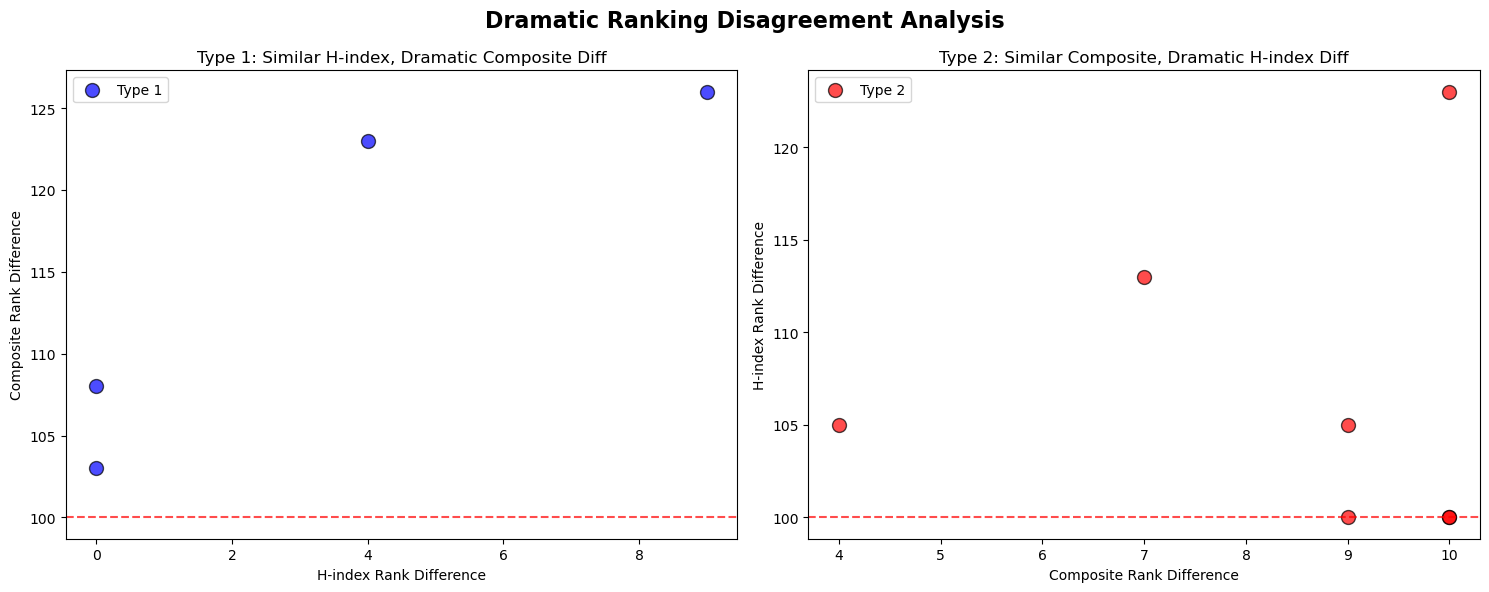


📋 SAMPLE DRAMATIC PAIRS
------------------------------------------------------------
TYPE 1 - Similar H-index, Dramatic Composite Difference:
  Pair 1: Xiaodong Liu vs V. Castro
    H-ranks: #149 vs #145 (diff: 4)
    Comp-ranks: #59 vs #182 (diff: 123)
  Pair 2: F. Matthes vs Bill Yuchen Lin
    H-ranks: #149 vs #158 (diff: 9)
    Comp-ranks: #77 vs #203 (diff: 126)
  Pair 3: Thomas Wolf vs Yonghui Wu
    H-ranks: #163 vs #163 (diff: 0)
    Comp-ranks: #107 vs #210 (diff: 103)

TYPE 2 - Similar Composite, Dramatic H-index Difference:
  Pair 1: Xuanjing Huang vs Xiaodong Liu
    Comp-ranks: #50 vs #59 (diff: 9)
    H-ranks: #44 vs #149 (diff: 105)
  Pair 2: G. Savova vs D. Klakow
    Comp-ranks: #93 vs #103 (diff: 10)
    H-ranks: #58 vs #181 (diff: 123)
  Pair 3: Chuang Gan vs Thomas Wolf
    Comp-ranks: #100 vs #107 (diff: 7)
    H-ranks: #50 vs #163 (diff: 113)

💡 Ready for final export (no intermediate files saved)


In [62]:
# Track Selection Process - Analysis Only (No File Saving)
print("📊 SELECTION PROCESS ANALYSIS")
print("=" * 60)

if 'selected_pairs' in locals() and selected_pairs:
    # Analyze the selected pairs
    type1_pairs = [p for p in selected_pairs if p['pair_type'] == 'type1_similar_h_dramatic_composite']
    type2_pairs = [p for p in selected_pairs if p['pair_type'] == 'type2_similar_composite_dramatic_h']
    
    print("Selection Success Metrics:")
    print(f"  ✅ Total candidate pool: {len(df_filtered) if 'df_filtered' in locals() else 0}")
    print(f"  ✅ Type 1 pairs selected: {len(type1_pairs)}")
    print(f"  ✅ Type 2 pairs selected: {len(type2_pairs)}")
    print(f"  ✅ Total pairs: {len(selected_pairs)}")
    print(f"  ✅ Researchers utilized: {len(selected_pairs) * 2}")
    
    # Calculate averages for each type
    if type1_pairs:
        avg_h_diff_type1 = np.mean([p['differences']['h_index_rank_diff'] for p in type1_pairs])
        avg_comp_diff_type1 = np.mean([p['differences']['composite_rank_diff'] for p in type1_pairs])
        print(f"  ✅ Type 1 - Avg H-index diff: {avg_h_diff_type1:.1f}, Avg composite diff: {avg_comp_diff_type1:.1f}")
    
    if type2_pairs:
        avg_h_diff_type2 = np.mean([p['differences']['h_index_rank_diff'] for p in type2_pairs])
        avg_comp_diff_type2 = np.mean([p['differences']['composite_rank_diff'] for p in type2_pairs])
        print(f"  ✅ Type 2 - Avg H-index diff: {avg_h_diff_type2:.1f}, Avg composite diff: {avg_comp_diff_type2:.1f}")
    
    # Quick visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Dramatic Ranking Disagreement Analysis', fontsize=16, fontweight='bold')
    
    # Type 1: H-index vs Composite differences
    if type1_pairs:
        h_diffs_1 = [p['differences']['h_index_rank_diff'] for p in type1_pairs]
        comp_diffs_1 = [p['differences']['composite_rank_diff'] for p in type1_pairs]
        axes[0].scatter(h_diffs_1, comp_diffs_1, alpha=0.7, s=100, c='blue', edgecolors='black', label='Type 1')
        axes[0].axhline(SELECTION_CRITERIA['min_dramatic_diff'], color='red', linestyle='--', alpha=0.7)
        axes[0].set_title('Type 1: Similar H-index, Dramatic Composite Diff')
        axes[0].set_xlabel('H-index Rank Difference')
        axes[0].set_ylabel('Composite Rank Difference')
        axes[0].legend()
    
    # Type 2: Composite vs H-index differences
    if type2_pairs:
        h_diffs_2 = [p['differences']['h_index_rank_diff'] for p in type2_pairs]
        comp_diffs_2 = [p['differences']['composite_rank_diff'] for p in type2_pairs]
        axes[1].scatter(comp_diffs_2, h_diffs_2, alpha=0.7, s=100, c='red', edgecolors='black', label='Type 2')
        axes[1].axhline(SELECTION_CRITERIA['min_dramatic_diff'], color='red', linestyle='--', alpha=0.7)
        axes[1].set_title('Type 2: Similar Composite, Dramatic H-index Diff')
        axes[1].set_xlabel('Composite Rank Difference')
        axes[1].set_ylabel('H-index Rank Difference')
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show sample pairs for verification
    print(f"\n📋 SAMPLE DRAMATIC PAIRS")
    print("-" * 60)
    
    # Show top Type 1 pairs
    if type1_pairs:
        print("TYPE 1 - Similar H-index, Dramatic Composite Difference:")
        for i, pair in enumerate(type1_pairs[:3], 1):  # Show first 3
            better = pair['better_researcher']
            worse = pair['worse_researcher']
            diff = pair['differences']
            print(f"  Pair {i}: {better['name'][:30]} vs {worse['name'][:30]}")
            print(f"    H-ranks: #{better['h_index_rank']} vs #{worse['h_index_rank']} (diff: {diff['h_index_rank_diff']})")
            print(f"    Comp-ranks: #{better['composite_rank']} vs #{worse['composite_rank']} (diff: {diff['composite_rank_diff']})")
    
    print()
    
    # Show top Type 2 pairs
    if type2_pairs:
        print("TYPE 2 - Similar Composite, Dramatic H-index Difference:")
        for i, pair in enumerate(type2_pairs[:3], 1):  # Show first 3
            better = pair['better_researcher']
            worse = pair['worse_researcher']
            diff = pair['differences']
            print(f"  Pair {i}: {better['name'][:30]} vs {worse['name'][:30]}")
            print(f"    Comp-ranks: #{better['composite_rank']} vs #{worse['composite_rank']} (diff: {diff['composite_rank_diff']})")
            print(f"    H-ranks: #{better['h_index_rank']} vs #{worse['h_index_rank']} (diff: {diff['h_index_rank_diff']})")
    
    print(f"\n💡 Ready for final export (no intermediate files saved)")

else:
    print("❌ No pairs selected - cannot generate analysis")

In [63]:
# Export Selected Pairs - FINAL OUTPUT ONLY
print("📦 EXPORTING FINAL SURVEY PAIRS (NO INTERMEDIATE FILES)")
print("=" * 60)

if 'selected_pairs' in locals() and selected_pairs:
    
    # 1. Create survey-ready CSV with both pair types
    survey_data = []
    for pair in selected_pairs:
        better = pair['better_researcher']
        worse = pair['worse_researcher']
        diff = pair['differences']
        
        # Determine the comparison focus based on pair type
        if pair['pair_type'] == 'type1_similar_h_dramatic_composite':
            comparison_focus = "Similar H-index ranking, dramatically different composite ranking"
            question_context = f"Both researchers have similar citation impact (H-index ranks #{better['h_index_rank']} vs #{worse['h_index_rank']}). Who would you rank higher for overall research excellence?"
        else:  # type2
            comparison_focus = "Similar composite ranking, dramatically different H-index ranking"
            question_context = f"Both researchers have similar multi-dimensional scores (composite ranks #{better['composite_rank']} vs #{worse['composite_rank']}). Who has greater citation impact and influence?"
        
        survey_data.append({
            'pair_id': pair['pair_id'],
            'pair_type': pair['pair_type'],
            'comparison_focus': comparison_focus,
            'researcher_a_name': better['name'],
            'researcher_a_h_index': better['h_index'],
            'researcher_a_h_rank': better['h_index_rank'],
            'researcher_a_composite_rank': better['composite_rank'],
            'researcher_a_composite_score': better['composite_score'],
            'researcher_b_name': worse['name'],
            'researcher_b_h_index': worse['h_index'],
            'researcher_b_h_rank': worse['h_index_rank'],
            'researcher_b_composite_rank': worse['composite_rank'],
            'researcher_b_composite_score': worse['composite_score'],
            'h_rank_difference': diff['h_index_rank_diff'],
            'composite_rank_difference': diff['composite_rank_diff'],
            'dramatic_difference': diff['dramatic_diff'],
            'question_context': question_context
        })
    
    survey_df = pd.DataFrame(survey_data)
    survey_df.to_csv('survey_candidate_pairs_final.csv', index=False)
    
    print(f"✅ Survey data exported to 'survey_candidate_pairs_final.csv'")
    print(f"   Contains {len(survey_df)} pairs ready for survey platform")
    
    # 2. Create survey questions with proper context for each type
    survey_questions = []
    for _, row in survey_df.iterrows():
        if row['pair_type'] == 'type1_similar_h_dramatic_composite':
            question = {
                'question_id': f"Q{int(row['pair_id'])}",
                'question_type': 'Type1_SimilarH_DramaticComposite',
                'question_text': row['question_context'],
                'researcher_a': {
                    'name': row['researcher_a_name'],
                    'h_index': int(row['researcher_a_h_index']),
                    'h_rank': f"#{int(row['researcher_a_h_rank'])}",
                    'composite_rank': f"#{int(row['researcher_a_composite_rank'])}"
                },
                'researcher_b': {
                    'name': row['researcher_b_name'], 
                    'h_index': int(row['researcher_b_h_index']),
                    'h_rank': f"#{int(row['researcher_b_h_rank'])}",
                    'composite_rank': f"#{int(row['researcher_b_composite_rank'])}"
                },
                'context': f"Similar H-index rankings (diff: {int(row['h_rank_difference'])}), Dramatic composite difference ({int(row['composite_rank_difference'])} positions)",
                'answer_options': ['Researcher A', 'Researcher B', 'Unable to determine']
            }
        else:  # Type 2
            question = {
                'question_id': f"Q{int(row['pair_id'])}",
                'question_type': 'Type2_SimilarComposite_DramaticH',
                'question_text': row['question_context'],
                'researcher_a': {
                    'name': row['researcher_a_name'],
                    'composite_rank': f"#{int(row['researcher_a_composite_rank'])}",
                    'h_index': int(row['researcher_a_h_index']),
                    'h_rank': f"#{int(row['researcher_a_h_rank'])}"
                },
                'researcher_b': {
                    'name': row['researcher_b_name'], 
                    'composite_rank': f"#{int(row['researcher_b_composite_rank'])}",
                    'h_index': int(row['researcher_b_h_index']),
                    'h_rank': f"#{int(row['researcher_b_h_rank'])}"
                },
                'context': f"Similar composite rankings (diff: {int(row['composite_rank_difference'])}), Dramatic H-index difference ({int(row['h_rank_difference'])} positions)",
                'answer_options': ['Researcher A', 'Researcher B', 'Unable to determine']
            }
        survey_questions.append(question)
    
    with open('survey_questions_final.json', 'w') as f:
        json.dump(survey_questions, f, indent=2)
    
    print(f"✅ Survey questions saved to 'survey_questions_final.json'")
    
    # 3. Create final summary statistics
    type1_count = len([p for p in selected_pairs if p['pair_type'] == 'type1_similar_h_dramatic_composite'])
    type2_count = len([p for p in selected_pairs if p['pair_type'] == 'type2_similar_composite_dramatic_h'])
    
    print(f"\n📊 FINAL EXPORT SUMMARY")
    print("-" * 40)
    print(f"Total pairs exported: {len(selected_pairs)}")
    print(f"  • Type 1 (Similar H-index, Dramatic Composite): {type1_count}")
    print(f"  • Type 2 (Similar Composite, Dramatic H-index): {type2_count}")
    print(f"Researchers involved: {len(selected_pairs) * 2}")
    print(f"Dramatic differences: All ≥{SELECTION_CRITERIA['min_dramatic_diff']} positions")
    
    # Show top dramatic pairs
    print(f"\n🏆 TOP 5 MOST DRAMATIC PAIRS:")
    print("-" * 60)
    
    # Sort by dramatic difference and show top 5
    sorted_pairs = sorted(selected_pairs, key=lambda x: x['differences']['dramatic_diff'], reverse=True)[:5]
    for i, pair in enumerate(sorted_pairs, 1):
        better = pair['better_researcher']
        worse = pair['worse_researcher']
        diff = pair['differences']
        pair_type = "Type 1" if pair['pair_type'] == 'type1_similar_h_dramatic_composite' else "Type 2"
        
        print(f"{i}. {pair_type} - {better['name'][:25]} vs {worse['name'][:25]}")
        print(f"   H-ranks: #{better['h_index_rank']} vs #{worse['h_index_rank']} (diff: {diff['h_index_rank_diff']})")
        print(f"   Comp-ranks: #{better['composite_rank']} vs #{worse['composite_rank']} (diff: {diff['composite_rank_diff']})")
        print(f"   Dramatic difference: {diff['dramatic_diff']} positions")
        print()
    
    print(f"🎯 READY FOR SURVEY DEPLOYMENT!")
    print(f"   Main data: survey_candidate_pairs_final.csv")
    print(f"   Questions: survey_questions_final.json")
    print(f"   Both pair types included for comprehensive validation")
    print(f"   All differences ≥100 positions for clear expert choices")
    
else:
    print("❌ No pairs available for export")
    print("   Please run the pair selection process first")

📦 EXPORTING FINAL SURVEY PAIRS (NO INTERMEDIATE FILES)
✅ Survey data exported to 'survey_candidate_pairs_final.csv'
   Contains 11 pairs ready for survey platform
✅ Survey questions saved to 'survey_questions_final.json'

📊 FINAL EXPORT SUMMARY
----------------------------------------
Total pairs exported: 11
  • Type 1 (Similar H-index, Dramatic Composite): 4
  • Type 2 (Similar Composite, Dramatic H-index): 7
Researchers involved: 22
Dramatic differences: All ≥100 positions

🏆 TOP 5 MOST DRAMATIC PAIRS:
------------------------------------------------------------
1. Type 1 - F. Matthes vs Bill Yuchen Lin
   H-ranks: #149 vs #158 (diff: 9)
   Comp-ranks: #77 vs #203 (diff: 126)
   Dramatic difference: 126 positions

2. Type 1 - Xiaodong Liu vs V. Castro
   H-ranks: #149 vs #145 (diff: 4)
   Comp-ranks: #59 vs #182 (diff: 123)
   Dramatic difference: 123 positions

3. Type 2 - G. Savova vs D. Klakow
   H-ranks: #58 vs #181 (diff: 123)
   Comp-ranks: #93 vs #103 (diff: 10)
   Dramatic d

## Survey Deployment Checklist

### ✅ Data Ready
- [ ] `survey_candidate_pairs_final.csv` - Main survey data
- [ ] `survey_questions_formatted.json` - Ready-to-import questions
- [ ] `survey_export_metadata.json` - Complete documentation

### ✅ Quality Assurance
- [ ] All pairs meet selection criteria (H-index similarity + composite difference)
- [ ] Researcher names are recognizable in the field
- [ ] Ranking differences are significant enough to test preferences
- [ ] Selection process is documented and reproducible

### 📋 Next Steps
1. **Platform Setup**: Import questions into survey platform (Qualtrics, Google Forms, etc.)
2. **Pilot Testing**: Test with 3-5 participants to validate timing and clarity
3. **Participant Recruitment**: Target NLP/AI researchers via conferences, mailing lists
4. **Data Collection**: Aim for 50+ responses for statistical significance
5. **Analysis**: Compare expert preferences with ranking systems

### 💡 Survey Tips
- **Randomize pair order** to prevent order effects
- **Randomize researcher order within pairs** (A/B positions)
- **Provide brief context** about similar H-index rankings
- **Include exit questions** about ranking criteria preferences
- **Estimate 15-20 minutes** completion time

---
*This notebook provides a complete, documented methodology for selecting survey candidates to validate the Beyond-H-Index ranking system through expert peer review.*

In [64]:
survey_df

,pair_id,pair_type,comparison_focus,researcher_a_name,researcher_a_h_index,researcher_a_h_rank,researcher_a_composite_rank,researcher_a_composite_score,researcher_b_name,researcher_b_h_index,researcher_b_h_rank,researcher_b_composite_rank,researcher_b_composite_score,h_rank_difference,composite_rank_difference,dramatic_difference,question_context
0,1,type1_similar_h_dramatic_composite,"Similar H-index ranking, dramatically differen...",Xiaodong Liu,37,149,59,0.234358,V. Castro,38,145,182,0.140713,4,123,123,Both researchers have similar citation impact ...
1,2,type1_similar_h_dramatic_composite,"Similar H-index ranking, dramatically differen...",F. Matthes,37,149,77,0.210318,Bill Yuchen Lin,35,158,203,0.131953,9,126,126,Both researchers have similar citation impact ...
2,3,type1_similar_h_dramatic_composite,"Similar H-index ranking, dramatically differen...",Thomas Wolf,34,163,107,0.186366,Yonghui Wu,34,163,210,0.125926,0,103,103,Both researchers have similar citation impact ...
3,4,type1_similar_h_dramatic_composite,"Similar H-index ranking, dramatically differen...",D. Klakow,33,181,103,0.187806,Dat Quoc Nguyen,33,181,211,0.125825,0,108,108,Both researchers have similar citation impact ...
4,5,type2_similar_composite_dramatic_h,"Similar composite ranking, dramatically differ...",Xuanjing Huang,64,44,50,0.251929,Xiaodong Liu,37,149,59,0.234358,105,9,105,Both researchers have similar multi-dimensiona...
5,6,type2_similar_composite_dramatic_h,"Similar composite ranking, dramatically differ...",G. Savova,58,58,93,0.196987,D. Klakow,33,181,103,0.187806,123,10,123,Both researchers have similar multi-dimensiona...
6,7,type2_similar_composite_dramatic_h,"Similar composite ranking, dramatically differ...",Chuang Gan,60,50,100,0.191935,Thomas Wolf,34,163,107,0.186366,113,7,113,Both researchers have similar multi-dimensiona...
7,8,type2_similar_composite_dramatic_h,"Similar composite ranking, dramatically differ...",Jacob Eisenstein,53,76,113,0.181818,Fu Lee Wang,33,181,117,0.174525,105,4,105,Both researchers have similar multi-dimensiona...
8,9,type2_similar_composite_dramatic_h,"Similar composite ranking, dramatically differ...",M. Salathé,45,101,121,0.168327,Stella Biderman,31,201,130,0.161120,100,9,100,Both researchers have similar multi-dimensiona...
9,10,type2_similar_composite_dramatic_h,"Similar composite ranking, dramatically differ...",E. Boyer,45,101,122,0.165887,M. Costa-jussà,31,201,132,0.160763,100,10,100,Both researchers have similar multi-dimensiona...


📊 DETAILED SURVEY PAIR VISUALIZATIONS


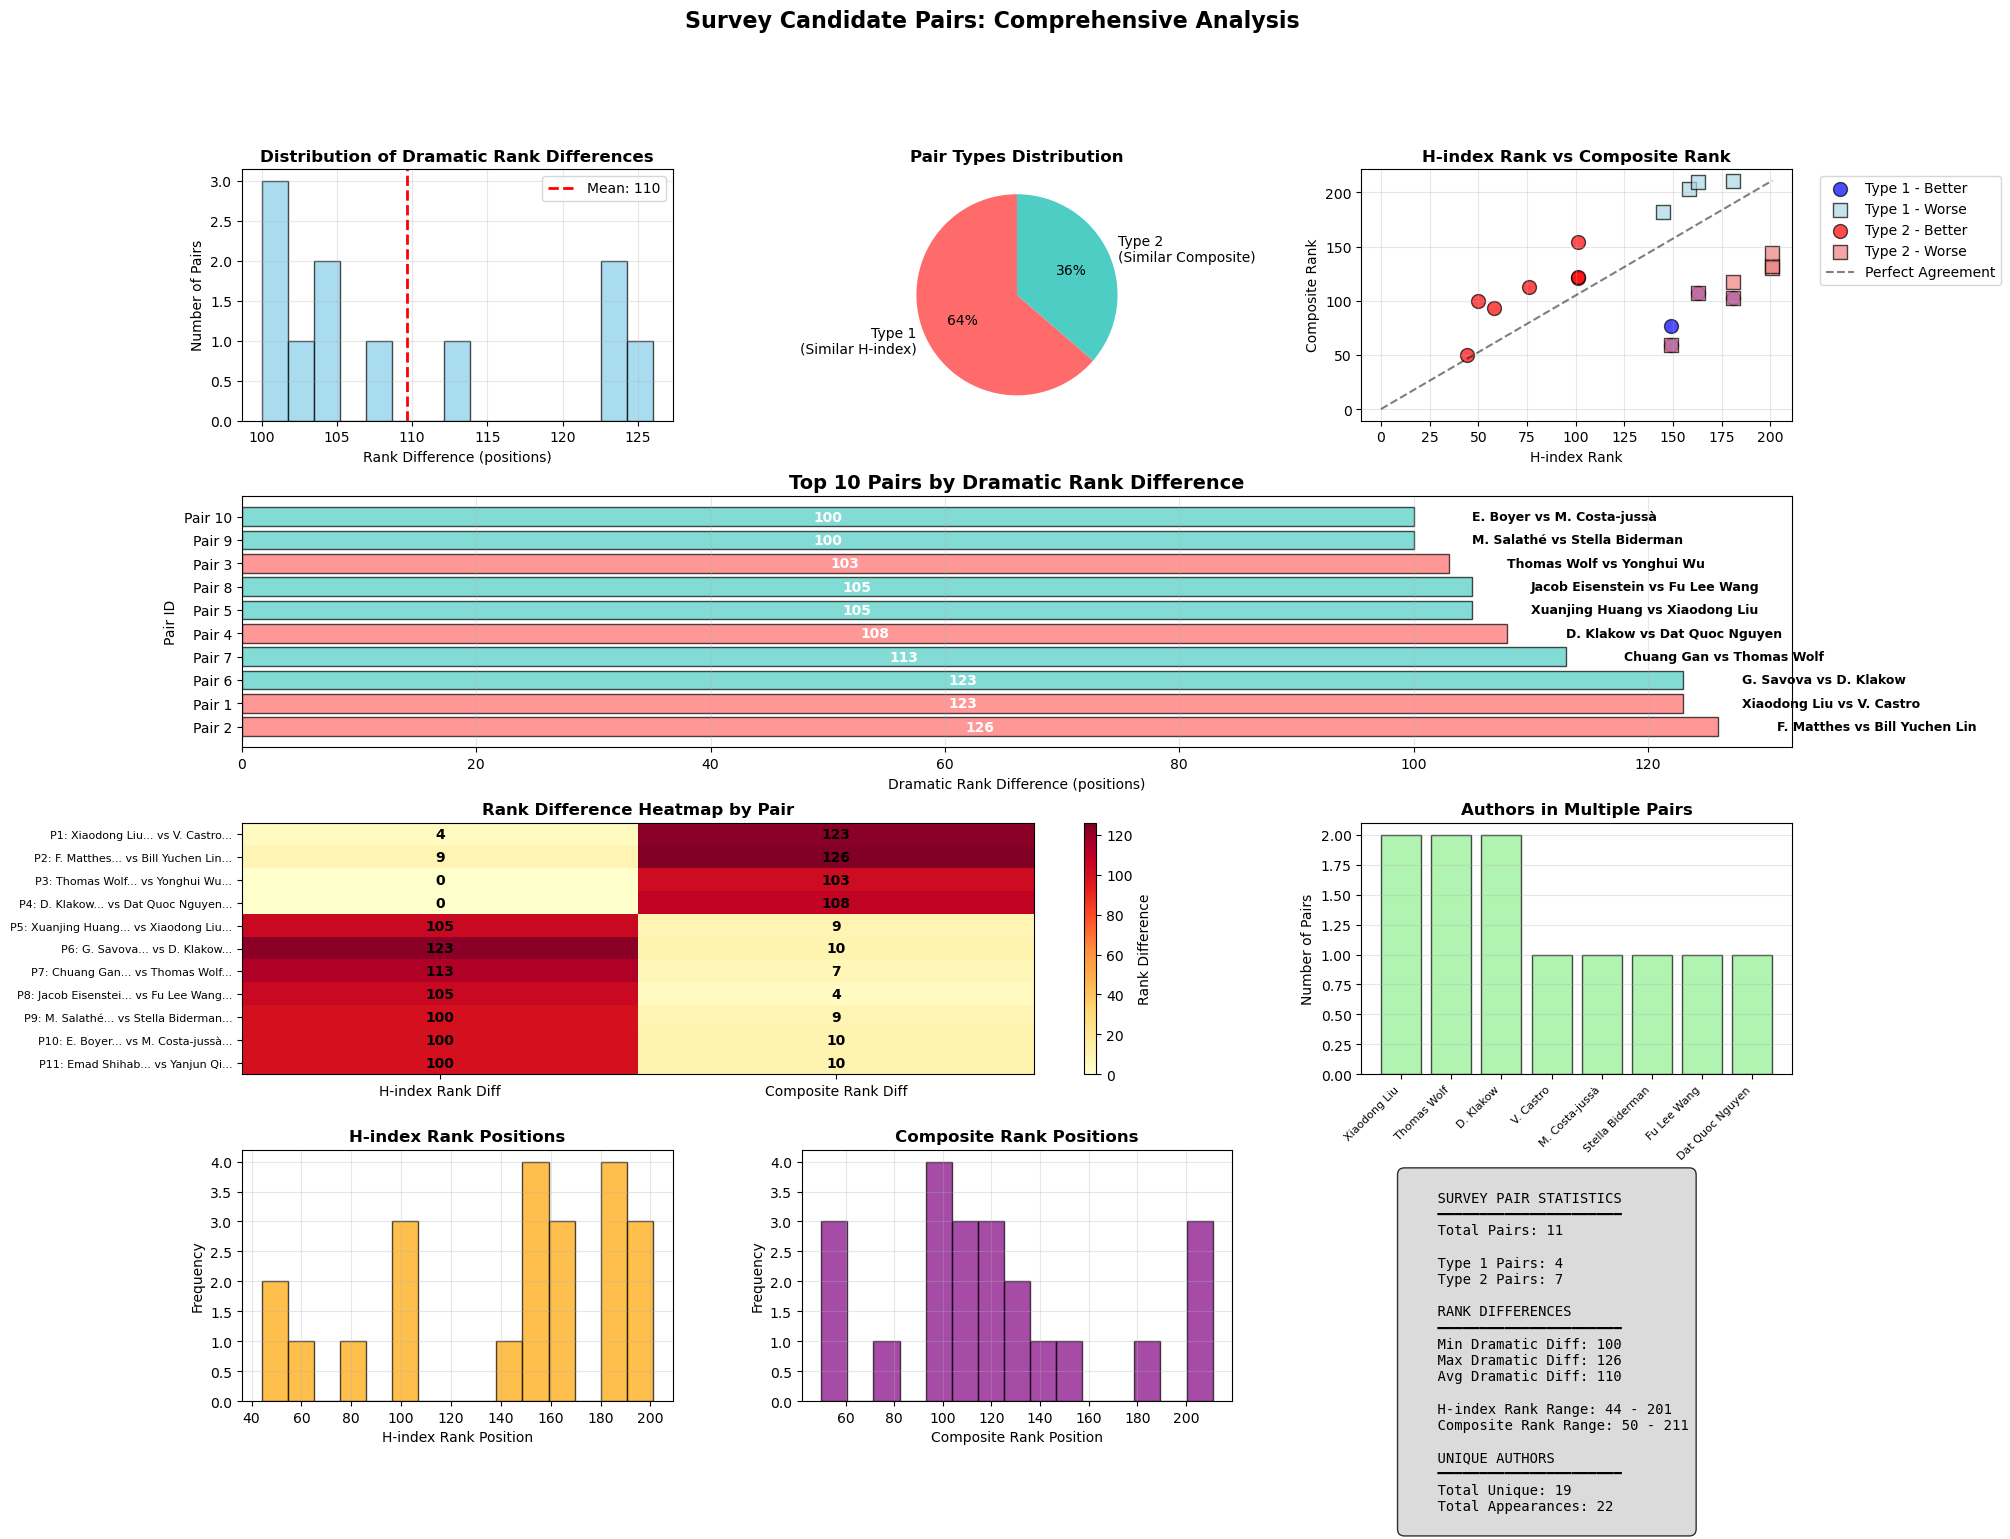


📋 DETAILED PAIR BREAKDOWN

Pair 1 (Type 1):
  👤 Researcher A: Xiaodong Liu
     H-index: 37 (rank #149)
     Composite: 0.234 (rank #59)
  👤 Researcher B: V. Castro
     H-index: 38 (rank #145)
     Composite: 0.141 (rank #182)
  📊 Differences: H-rank: 4, Composite-rank: 123
  🎯 Dramatic difference: 123 positions
  ❓ Survey question: Both researchers have similar citation impact (H-index ranks #149 vs #145). Who ...

Pair 2 (Type 1):
  👤 Researcher A: F. Matthes
     H-index: 37 (rank #149)
     Composite: 0.210 (rank #77)
  👤 Researcher B: Bill Yuchen Lin
     H-index: 35 (rank #158)
     Composite: 0.132 (rank #203)
  📊 Differences: H-rank: 9, Composite-rank: 126
  🎯 Dramatic difference: 126 positions
  ❓ Survey question: Both researchers have similar citation impact (H-index ranks #149 vs #158). Who ...

Pair 3 (Type 1):
  👤 Researcher A: Thomas Wolf
     H-index: 34 (rank #163)
     Composite: 0.186 (rank #107)
  👤 Researcher B: Yonghui Wu
     H-index: 34 (rank #163)
     Composi

In [65]:
# Detailed Visualization of Survey Pairs - Author Names and Rank Differences
print("📊 DETAILED SURVEY PAIR VISUALIZATIONS")
print("=" * 70)

if 'survey_df' in locals() and not survey_df.empty:
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a comprehensive figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # 1. Rank Differences Overview (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    rank_diffs = survey_df['dramatic_difference']
    ax1.hist(rank_diffs, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(rank_diffs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rank_diffs.mean():.0f}')
    ax1.set_title('Distribution of Dramatic Rank Differences', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Rank Difference (positions)')
    ax1.set_ylabel('Number of Pairs')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Pair Types Distribution (Top Center)
    ax2 = fig.add_subplot(gs[0, 1])
    type_counts = survey_df['pair_type'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4']
    wedges, texts, autotexts = ax2.pie(type_counts.values, labels=['Type 1\n(Similar H-index)', 'Type 2\n(Similar Composite)'], 
                                      autopct='%1.0f%%', colors=colors, startangle=90)
    ax2.set_title('Pair Types Distribution', fontsize=12, fontweight='bold')
    
    # 3. H-index vs Composite Rank Scatter (Top Right)
    ax3 = fig.add_subplot(gs[0, 2])
    # Plot all researchers from pairs
    h_ranks_all = list(survey_df['researcher_a_h_rank']) + list(survey_df['researcher_b_h_rank'])
    comp_ranks_all = list(survey_df['researcher_a_composite_rank']) + list(survey_df['researcher_b_composite_rank'])
    type1_mask = survey_df['pair_type'] == 'type1_similar_h_dramatic_composite'
    
    # Type 1 pairs
    ax3.scatter(survey_df[type1_mask]['researcher_a_h_rank'], survey_df[type1_mask]['researcher_a_composite_rank'], 
               c='blue', alpha=0.7, s=100, label='Type 1 - Better', marker='o', edgecolors='black')
    ax3.scatter(survey_df[type1_mask]['researcher_b_h_rank'], survey_df[type1_mask]['researcher_b_composite_rank'], 
               c='lightblue', alpha=0.7, s=100, label='Type 1 - Worse', marker='s', edgecolors='black')
    
    # Type 2 pairs
    type2_mask = ~type1_mask
    ax3.scatter(survey_df[type2_mask]['researcher_a_h_rank'], survey_df[type2_mask]['researcher_a_composite_rank'], 
               c='red', alpha=0.7, s=100, label='Type 2 - Better', marker='o', edgecolors='black')
    ax3.scatter(survey_df[type2_mask]['researcher_b_h_rank'], survey_df[type2_mask]['researcher_b_composite_rank'], 
               c='lightcoral', alpha=0.7, s=100, label='Type 2 - Worse', marker='s', edgecolors='black')
    
    ax3.plot([0, max(h_ranks_all)], [0, max(comp_ranks_all)], 'k--', alpha=0.5, label='Perfect Agreement')
    ax3.set_title('H-index Rank vs Composite Rank', fontsize=12, fontweight='bold')
    ax3.set_xlabel('H-index Rank')
    ax3.set_ylabel('Composite Rank')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Top Authors by Rank Differences (Second Row - Full Width)
    ax4 = fig.add_subplot(gs[1, :])
    
    # Prepare data for author comparison
    author_data = []
    for _, row in survey_df.iterrows():
        author_data.append({
            'pair_id': row['pair_id'],
            'author_a': row['researcher_a_name'][:25] + ('...' if len(row['researcher_a_name']) > 25 else ''),
            'author_b': row['researcher_b_name'][:25] + ('...' if len(row['researcher_b_name']) > 25 else ''),
            'h_rank_diff': row['h_rank_difference'],
            'comp_rank_diff': row['composite_rank_difference'],
            'dramatic_diff': row['dramatic_difference'],
            'pair_type': 'Type 1' if row['pair_type'] == 'type1_similar_h_dramatic_composite' else 'Type 2'
        })
    
    # Sort by dramatic difference and take top 10
    author_data_sorted = sorted(author_data, key=lambda x: x['dramatic_diff'], reverse=True)[:10]
    
    pair_labels = [f"Pair {item['pair_id']}" for item in author_data_sorted]
    dramatic_diffs = [item['dramatic_diff'] for item in author_data_sorted]
    colors_bar = ['#FF6B6B' if item['pair_type'] == 'Type 1' else '#4ECDC4' for item in author_data_sorted]
    
    bars = ax4.barh(pair_labels, dramatic_diffs, color=colors_bar, alpha=0.7, edgecolor='black')
    ax4.set_title('Top 10 Pairs by Dramatic Rank Difference', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Dramatic Rank Difference (positions)')
    ax4.set_ylabel('Pair ID')
    
    # Add value labels on bars
    for i, (bar, item) in enumerate(zip(bars, author_data_sorted)):
        width = bar.get_width()
        ax4.text(width + 5, bar.get_y() + bar.get_height()/2, 
                f"{item['author_a']} vs {item['author_b']}", 
                ha='left', va='center', fontsize=9, fontweight='bold')
        ax4.text(width/2, bar.get_y() + bar.get_height()/2, 
                f"{int(width)}", ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    
    ax4.grid(True, axis='x', alpha=0.3)
    
    # 5. Detailed Pair Comparison Matrix (Third Row)
    ax5 = fig.add_subplot(gs[2, :2])
    
    # Create a matrix showing rank differences
    pairs_to_show = min(12, len(survey_df))
    matrix_data = np.zeros((pairs_to_show, 2))
    pair_names = []
    
    for i in range(pairs_to_show):
        row = survey_df.iloc[i]
        matrix_data[i, 0] = row['h_rank_difference']
        matrix_data[i, 1] = row['composite_rank_difference']
        pair_names.append(f"P{row['pair_id']}: {row['researcher_a_name'][:15]}... vs {row['researcher_b_name'][:15]}...")
    
    im = ax5.imshow(matrix_data, cmap='YlOrRd', aspect='auto')
    ax5.set_xticks([0, 1])
    ax5.set_xticklabels(['H-index Rank Diff', 'Composite Rank Diff'])
    ax5.set_yticks(range(pairs_to_show))
    ax5.set_yticklabels(pair_names, fontsize=8)
    ax5.set_title('Rank Difference Heatmap by Pair', fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(pairs_to_show):
        for j in range(2):
            text = ax5.text(j, i, f'{int(matrix_data[i, j])}', 
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax5, label='Rank Difference')
    
    # 6. Author Name Analysis (Third Row - Right)
    ax6 = fig.add_subplot(gs[2, 2])
    
    # Count unique authors
    all_authors = list(survey_df['researcher_a_name']) + list(survey_df['researcher_b_name'])
    author_counts = pd.Series(all_authors).value_counts()
    
    if len(author_counts) > 0:
        # Show top authors appearing in multiple pairs
        top_authors = author_counts.head(8)
        if len(top_authors) > 0:
            ax6.bar(range(len(top_authors)), top_authors.values, 
                   color='lightgreen', alpha=0.7, edgecolor='black')
            ax6.set_xticks(range(len(top_authors)))
            ax6.set_xticklabels([name[:15] + '...' if len(name) > 15 else name for name in top_authors.index], 
                               rotation=45, ha='right', fontsize=8)
            ax6.set_title('Authors in Multiple Pairs', fontsize=12, fontweight='bold')
            ax6.set_ylabel('Number of Pairs')
            ax6.grid(True, axis='y', alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'No repeated authors', ha='center', va='center', transform=ax6.transAxes)
    
    # 7. Ranking Position Analysis (Fourth Row)
    ax7 = fig.add_subplot(gs[3, 0])
    
    # H-index ranking positions
    h_positions = list(survey_df['researcher_a_h_rank']) + list(survey_df['researcher_b_h_rank'])
    ax7.hist(h_positions, bins=15, alpha=0.7, color='orange', edgecolor='black')
    ax7.set_title('H-index Rank Positions', fontsize=12, fontweight='bold')
    ax7.set_xlabel('H-index Rank Position')
    ax7.set_ylabel('Frequency')
    ax7.grid(True, alpha=0.3)
    
    # 8. Composite ranking positions
    ax8 = fig.add_subplot(gs[3, 1])
    
    comp_positions = list(survey_df['researcher_a_composite_rank']) + list(survey_df['researcher_b_composite_rank'])
    ax8.hist(comp_positions, bins=15, alpha=0.7, color='purple', edgecolor='black')
    ax8.set_title('Composite Rank Positions', fontsize=12, fontweight='bold')
    ax8.set_xlabel('Composite Rank Position')
    ax8.set_ylabel('Frequency')
    ax8.grid(True, alpha=0.3)
    
    # 9. Summary Statistics (Fourth Row - Right)
    ax9 = fig.add_subplot(gs[3, 2])
    ax9.axis('off')
    
    # Calculate summary statistics
    stats_text = f"""
    SURVEY PAIR STATISTICS
    ━━━━━━━━━━━━━━━━━━━━━━
    Total Pairs: {len(survey_df)}
    
    Type 1 Pairs: {len(survey_df[survey_df['pair_type'] == 'type1_similar_h_dramatic_composite'])}
    Type 2 Pairs: {len(survey_df[survey_df['pair_type'] == 'type2_similar_composite_dramatic_h'])}
    
    RANK DIFFERENCES
    ━━━━━━━━━━━━━━━━━━━━━━
    Min Dramatic Diff: {survey_df['dramatic_difference'].min():.0f}
    Max Dramatic Diff: {survey_df['dramatic_difference'].max():.0f}
    Avg Dramatic Diff: {survey_df['dramatic_difference'].mean():.0f}
    
    H-index Rank Range: {min(h_positions):.0f} - {max(h_positions):.0f}
    Composite Rank Range: {min(comp_positions):.0f} - {max(comp_positions):.0f}
    
    UNIQUE AUTHORS
    ━━━━━━━━━━━━━━━━━━━━━━
    Total Unique: {len(set(all_authors))}
    Total Appearances: {len(all_authors)}
    """
    
    ax9.text(0.1, 0.9, stats_text, transform=ax9.transAxes, fontsize=10, 
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.suptitle('Survey Candidate Pairs: Comprehensive Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Additional detailed table view
    print(f"\n📋 DETAILED PAIR BREAKDOWN")
    print("=" * 100)
    
    for i, (_, row) in enumerate(survey_df.iterrows(), 1):
        pair_type = "Type 1" if row['pair_type'] == 'type1_similar_h_dramatic_composite' else "Type 2"
        print(f"\nPair {row['pair_id']} ({pair_type}):")
        print(f"  👤 Researcher A: {row['researcher_a_name']}")
        print(f"     H-index: {row['researcher_a_h_index']} (rank #{row['researcher_a_h_rank']})")
        print(f"     Composite: {row['researcher_a_composite_score']:.3f} (rank #{row['researcher_a_composite_rank']})")
        print(f"  👤 Researcher B: {row['researcher_b_name']}")
        print(f"     H-index: {row['researcher_b_h_index']} (rank #{row['researcher_b_h_rank']})")
        print(f"     Composite: {row['researcher_b_composite_score']:.3f} (rank #{row['researcher_b_composite_rank']})")
        print(f"  📊 Differences: H-rank: {row['h_rank_difference']}, Composite-rank: {row['composite_rank_difference']}")
        print(f"  🎯 Dramatic difference: {row['dramatic_difference']} positions")
        print(f"  ❓ Survey question: {row['question_context'][:80]}...")
        
        if i >= 5:  # Show first 5 pairs in detail
            remaining = len(survey_df) - 5
            if remaining > 0:
                print(f"\n... and {remaining} more pairs (see visualization above)")
            break
    
    print(f"\n✅ Comprehensive visualization complete!")
    print(f"📊 All {len(survey_df)} pairs visualized with author details and rank differences")

else:
    print("❌ No survey data available for visualization")
    print("   Please run the pair selection and export process first")

In [ ]:
# Generate Interactive HTML Report for Survey Data
print("🌐 GENERATING INTERACTIVE HTML REPORT")
print("=" * 60)

if 'survey_df' in locals() and not survey_df.empty:
    
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    import plotly.offline as pyo
    from datetime import datetime
    
    # Create interactive plotly figures
    print("📊 Creating interactive visualizations...")
    
    # 1. Rank Differences Distribution
    fig1 = px.histogram(
        survey_df, 
        x='dramatic_difference',
        nbins=15,
        title='Distribution of Dramatic Rank Differences',
        labels={'dramatic_difference': 'Rank Difference (positions)', 'count': 'Number of Pairs'},
        color_discrete_sequence=['#FF6B6B']
    )
    fig1.add_vline(x=survey_df['dramatic_difference'].mean(), line_dash="dash", 
                   annotation_text=f"Mean: {survey_df['dramatic_difference'].mean():.0f}")
    
    # 2. Pair Types Distribution
    type_counts = survey_df['pair_type'].value_counts()
    fig2 = px.pie(
        values=type_counts.values,
        names=['Type 1: Similar H-index', 'Type 2: Similar Composite'],
        title='Pair Types Distribution',
        color_discrete_sequence=['#FF6B6B', '#4ECDC4']
    )
    
    # 3. H-index vs Composite Rank Scatter
    fig3 = go.Figure()
    
    # Add data points for both types
    type1_mask = survey_df['pair_type'] == 'type1_similar_h_dramatic_composite'
    
    # Type 1 pairs
    fig3.add_trace(go.Scatter(
        x=survey_df[type1_mask]['researcher_a_h_rank'],
        y=survey_df[type1_mask]['researcher_a_composite_rank'],
        mode='markers',
        name='Type 1 - Better Composite',
        marker=dict(color='blue', size=12, symbol='circle'),
        text=survey_df[type1_mask]['researcher_a_name'],
        hovertemplate='<b>%{text}</b><br>H-index Rank: %{x}<br>Composite Rank: %{y}<extra></extra>'
    ))
    
    fig3.add_trace(go.Scatter(
        x=survey_df[type1_mask]['researcher_b_h_rank'],
        y=survey_df[type1_mask]['researcher_b_composite_rank'],
        mode='markers',
        name='Type 1 - Worse Composite',
        marker=dict(color='lightblue', size=12, symbol='square'),
        text=survey_df[type1_mask]['researcher_b_name'],
        hovertemplate='<b>%{text}</b><br>H-index Rank: %{x}<br>Composite Rank: %{y}<extra></extra>'
    ))
    
    # Type 2 pairs
    type2_mask = ~type1_mask
    fig3.add_trace(go.Scatter(
        x=survey_df[type2_mask]['researcher_a_h_rank'],
        y=survey_df[type2_mask]['researcher_a_composite_rank'],
        mode='markers',
        name='Type 2 - Better H-index',
        marker=dict(color='red', size=12, symbol='circle'),
        text=survey_df[type2_mask]['researcher_a_name'],
        hovertemplate='<b>%{text}</b><br>H-index Rank: %{x}<br>Composite Rank: %{y}<extra></extra>'
    ))
    
    fig3.add_trace(go.Scatter(
        x=survey_df[type2_mask]['researcher_b_h_rank'],
        y=survey_df[type2_mask]['researcher_b_composite_rank'],
        mode='markers',
        name='Type 2 - Worse H-index',
        marker=dict(color='lightcoral', size=12, symbol='square'),
        text=survey_df[type2_mask]['researcher_b_name'],
        hovertemplate='<b>%{text}</b><br>H-index Rank: %{x}<br>Composite Rank: %{y}<extra></extra>'
    ))
    
    # Add diagonal line
    max_rank = max(survey_df[['researcher_a_h_rank', 'researcher_b_h_rank', 
                            'researcher_a_composite_rank', 'researcher_b_composite_rank']].max())
    fig3.add_trace(go.Scatter(
        x=[0, max_rank],
        y=[0, max_rank],
        mode='lines',
        name='Perfect Agreement',
        line=dict(color='black', dash='dash'),
        hoverinfo='skip'
    ))
    
    fig3.update_layout(
        title='H-index Rank vs Composite Rank (Interactive)',
        xaxis_title='H-index Rank',
        yaxis_title='Composite Rank',
        hovermode='closest'
    )
    
    # 4. Top Pairs by Dramatic Difference
    survey_df_sorted = survey_df.sort_values('dramatic_difference', ascending=True).tail(10)
    
    fig4 = go.Figure(go.Bar(
        x=survey_df_sorted['dramatic_difference'],
        y=[f"Pair {row['pair_id']}: {row['researcher_a_name'][:20]}... vs {row['researcher_b_name'][:20]}..." 
           for _, row in survey_df_sorted.iterrows()],
        orientation='h',
        marker_color=['#FF6B6B' if row['pair_type'] == 'type1_similar_h_dramatic_composite' else '#4ECDC4' 
                      for _, row in survey_df_sorted.iterrows()],
        text=survey_df_sorted['dramatic_difference'],
        textposition='inside',
        hovertemplate='<b>Pair %{customdata[0]}</b><br>' +
                      'Researcher A: %{customdata[1]}<br>' +
                      'Researcher B: %{customdata[2]}<br>' +
                      'Dramatic Difference: %{x} positions<br>' +
                      'H-index Diff: %{customdata[3]}<br>' +
                      'Composite Diff: %{customdata[4]}<extra></extra>',
        customdata=[[row['pair_id'], row['researcher_a_name'], row['researcher_b_name'], 
                    row['h_rank_difference'], row['composite_rank_difference']] 
                   for _, row in survey_df_sorted.iterrows()]
    ))
    
    fig4.update_layout(
        title='Top 10 Pairs by Dramatic Rank Difference (Interactive)',
        xaxis_title='Dramatic Rank Difference (positions)',
        yaxis_title='Pair Details',
        height=600
    )
    
    # Create HTML content
    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Beyond-H-Index Survey Candidate Analysis</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                margin: 0;
                padding: 20px;
                background-color: #f5f5f5;
            }}
            .header {{
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 30px;
                border-radius: 10px;
                margin-bottom: 30px;
                text-align: center;
            }}
            .container {{
                max-width: 1400px;
                margin: 0 auto;
            }}
            .chart-container {{
                background: white;
                margin: 20px 0;
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            }}
            .stats-grid {{
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
                gap: 20px;
                margin: 20px 0;
            }}
            .stat-card {{
                background: white;
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 2px 10px rgba(0,0,0,0.1);
                text-align: center;
            }}
            .stat-number {{
                font-size: 2em;
                font-weight: bold;
                color: #667eea;
            }}
            .pair-details {{
                background: white;
                margin: 20px 0;
                padding: 20px;
                border-radius: 10px;
                box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            }}
            .pair-item {{
                border-left: 4px solid #667eea;
                padding: 15px;
                margin: 10px 0;
                background: #f8f9ff;
                border-radius: 0 5px 5px 0;
            }}
            .type1 {{ border-left-color: #FF6B6B; }}
            .type2 {{ border-left-color: #4ECDC4; }}
            .researcher {{
                font-weight: bold;
                color: #333;
            }}
            .metrics {{
                color: #666;
                font-size: 0.9em;
                margin: 5px 0;
            }}
            h1, h2 {{
                color: #333;
            }}
            .footer {{
                text-align: center;
                margin-top: 50px;
                padding: 20px;
                color: #666;
                border-top: 1px solid #ddd;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>🎯 Beyond-H-Index Survey Candidate Analysis</h1>
                <p>Interactive visualization of researcher pairs for validation survey</p>
                <p>Generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>
            
            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-number">{len(survey_df)}</div>
                    <div>Total Pairs</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{len(survey_df[survey_df['pair_type'] == 'type1_similar_h_dramatic_composite'])}</div>
                    <div>Type 1 Pairs</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{len(survey_df[survey_df['pair_type'] == 'type2_similar_composite_dramatic_h'])}</div>
                    <div>Type 2 Pairs</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{survey_df['dramatic_difference'].mean():.0f}</div>
                    <div>Avg Dramatic Diff</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{survey_df['dramatic_difference'].max():.0f}</div>
                    <div>Max Dramatic Diff</div>
                </div>
                <div class="stat-card">
                    <div class="stat-number">{len(set(list(survey_df['researcher_a_name']) + list(survey_df['researcher_b_name'])))}</div>
                    <div>Unique Authors</div>
                </div>
            </div>
            
            <div class="chart-container">
                <h2>📊 Dramatic Rank Differences Distribution</h2>
                <div id="chart1"></div>
            </div>
            
            <div class="chart-container">
                <h2>🥧 Pair Types Distribution</h2>
                <div id="chart2"></div>
            </div>
            
            <div class="chart-container">
                <h2>🎯 H-index vs Composite Ranking (Interactive)</h2>
                <p>Hover over points to see researcher details. Points further from the diagonal show greater ranking disagreement.</p>
                <div id="chart3"></div>
            </div>
            
            <div class="chart-container">
                <h2>🏆 Top Pairs by Dramatic Difference (Interactive)</h2>
                <p>Hover over bars to see detailed researcher information and ranking differences.</p>
                <div id="chart4"></div>
            </div>
            
            <div class="pair-details">
                <h2>📋 Detailed Pair Breakdown</h2>
    """
    
    # Add detailed pair information
    for _, row in survey_df.iterrows():
        pair_type_class = "type1" if row['pair_type'] == 'type1_similar_h_dramatic_composite' else "type2"
        pair_type_name = "Type 1" if row['pair_type'] == 'type1_similar_h_dramatic_composite' else "Type 2"
        
        html_content += f"""
                <div class="pair-item {pair_type_class}">
                    <h3>Pair {row['pair_id']} ({pair_type_name})</h3>
                    <div class="researcher">👤 Researcher A: {row['researcher_a_name']}</div>
                    <div class="metrics">
                        📈 H-index: {row['researcher_a_h_index']} (rank #{row['researcher_a_h_rank']}) | 
                        🎯 Composite: {row['researcher_a_composite_score']:.3f} (rank #{row['researcher_a_composite_rank']})
                    </div>
                    <div class="researcher">👤 Researcher B: {row['researcher_b_name']}</div>
                    <div class="metrics">
                        📈 H-index: {row['researcher_b_h_index']} (rank #{row['researcher_b_h_rank']}) | 
                        🎯 Composite: {row['researcher_b_composite_score']:.3f} (rank #{row['researcher_b_composite_rank']})
                    </div>
                    <div class="metrics">
                        🔄 Differences: H-index rank: {row['h_rank_difference']}, Composite rank: {row['composite_rank_difference']} | 
                        🎯 Dramatic difference: {row['dramatic_difference']} positions
                    </div>
                    <div class="metrics">
                        ❓ Survey question: {row['question_context']}
                    </div>
                </div>
        """
    
    html_content += f"""
            </div>
            
            <div class="footer">
                <p>Beyond-H-Index Survey Candidate Analysis | Generated {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
                <p>This interactive report shows researcher pairs selected for survey validation of the Beyond-H-Index ranking system.</p>
            </div>
        </div>
        
        <script>
            // Render the charts using Plotly's to_json method
            var chart1_data = {fig1.to_json()};
            var chart2_data = {fig2.to_json()};
            var chart3_data = {fig3.to_json()};
            var chart4_data = {fig4.to_json()};
            
            Plotly.newPlot('chart1', chart1_data.data, chart1_data.layout);
            Plotly.newPlot('chart2', chart2_data.data, chart2_data.layout);
            Plotly.newPlot('chart3', chart3_data.data, chart3_data.layout);
            Plotly.newPlot('chart4', chart4_data.data, chart4_data.layout);
        </script>
    </body>
    </html>
    """
    
    # Save HTML file
    filename = 'survey_candidate_analysis.html'
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"✅ Interactive HTML report generated: '{filename}'")
    print(f"📊 Features included:")
    print(f"   • Interactive plotly charts with hover details")
    print(f"   • Responsive design with modern styling")
    print(f"   • Detailed statistics and metrics")
    print(f"   • Complete pair breakdown with researcher details")
    print(f"   • Color-coded pair types throughout")
    print(f"   • Professional layout ready for presentation")
    
    print(f"\n🌐 Open the file in your browser to view the interactive report!")
    print(f"   File location: {filename}")
    
    # Also create a simple table HTML for quick reference
    table_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Survey Pairs - Quick Reference</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            table {{ border-collapse: collapse; width: 100%; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #f2f2f2; }}
            .type1 {{ background-color: #ffe6e6; }}
            .type2 {{ background-color: #e6f7ff; }}
        </style>
    </head>
    <body>
        <h1>Survey Candidate Pairs - Quick Reference Table</h1>
        <table>
            <tr>
                <th>Pair ID</th>
                <th>Type</th>
                <th>Researcher A</th>
                <th>Researcher B</th>
                <th>H-index Ranks</th>
                <th>Composite Ranks</th>
                <th>Dramatic Diff</th>
            </tr>
    """
    
    for _, row in survey_df.iterrows():
        pair_type_class = "type1" if row['pair_type'] == 'type1_similar_h_dramatic_composite' else "type2"
        pair_type_name = "Type 1" if row['pair_type'] == 'type1_similar_h_dramatic_composite' else "Type 2"
        
        table_html += f"""
            <tr class="{pair_type_class}">
                <td>{row['pair_id']}</td>
                <td>{pair_type_name}</td>
                <td>{row['researcher_a_name']}</td>
                <td>{row['researcher_b_name']}</td>
                <td>#{row['researcher_a_h_rank']} vs #{row['researcher_b_h_rank']}</td>
                <td>#{row['researcher_a_composite_rank']} vs #{row['researcher_b_composite_rank']}</td>
                <td>{row['dramatic_difference']}</td>
            </tr>
        """
    
    table_html += """
        </table>
    </body>
    </html>
    """
    
    with open('survey_pairs_table.html', 'w', encoding='utf-8') as f:
        f.write(table_html)
    
    print(f"✅ Quick reference table also created: 'survey_pairs_table.html'")

else:
    print("❌ No survey data available for HTML export")
    print("   Please run the pair selection and export process first")

🌐 GENERATING INTERACTIVE HTML REPORT
📊 Creating interactive visualizations...


TypeError: Object of type ndarray is not JSON serializable